In [1]:
!pip install category_encoders

     |████████████████████████████████| 80 kB 6.4 MB/s 


In [2]:
!pip install neptune-client

     |████████████████████████████████| 243 kB 30.7 MB/s 
     |████████████████████████████████| 829 kB 27.9 MB/s 
     |████████████████████████████████| 68 kB 6.8 MB/s 
     |████████████████████████████████| 170 kB 50.5 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 129 kB 53.6 MB/s 
     |████████████████████████████████| 67 kB 5.9 MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.10.2-py2.py3-none-any.whl size=424909 sha256=0e3029ec7bd6786d78b9723a58f4191b344faa04ba43ae1dfe07428208fd885e
  Stored in directory: /root/.cache/pip/wheels/e9/ac/d7/15fa2be10dc2b4aee3d51d94e3ad1a62ae11642ae7a51f571a
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=ee59723fe4982c829b5630fa2e7d90c0650a2ddc4718ea5988b9c891b25be088
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

import six
import sys
sys.modules['sklearn.externals.six'] = six

from imblearn.combine import SMOTETomek
from datetime import datetime
from sklearn.compose import ColumnTransformer

from sklearn.metrics import classification_report, make_scorer, f1_score, precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold

from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform
import matplotlib.pyplot as plt

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import xgboost as xgb

from sklearn.model_selection import train_test_split

from sklearn.metrics import plot_confusion_matrix


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
import neptune

API_TOKEN=''' #@param {type:"string"}

PROJEKT_NAME = 'DataWorkshop-Foundation/Predicting-cancellation-of-visit' 

neptune.init(
   api_token=API_TOKEN,
   project_qualified_name=PROJEKT_NAME
)

Project(DataWorkshop-Foundation/Predicting-cancellation-of-visit)

In [5]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Cancellation/data/KaggleV2-May-2016.csv')
dataset

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572134e+12,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3.596266e+12,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,1.557663e+13,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,9.213493e+13,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No


In [6]:
#patientID
dataset['PatientId'] = dataset['PatientId'].astype('int64') 

#AppointmentID
dataset['AppointmentID'] = dataset['AppointmentID'].astype('int64') 
dataset.drop(dataset[dataset['AppointmentID'].isna()].index, inplace = True)

#gender
dataset['Gender'] = dataset['Gender'].map({'F':1, 'M':0})

#neiberhood

import category_encoders as ce

encoder = ce.OneHotEncoder(cols=['Neighbourhood'])
dataset = encoder.fit_transform(dataset)

#Age

dataset = dataset[dataset['Age'] >=0]

#no-show
dataset['No-show'] = dataset['No-show'].map({'Yes':1, 'No':0})

# #date
dataset['ScheduledDay'] = dataset['ScheduledDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))


dataset['AppointmentDay'] = dataset['AppointmentDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))




/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [7]:
dataset

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_49,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296,5642903,1,2016-04-29 18:38:08,2016-04-29,62,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,558997776694438,5642503,0,2016-04-29 16:08:27,2016-04-29,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4262962299951,5642549,1,2016-04-29 16:19:04,2016-04-29,62,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,867951213174,5642828,1,2016-04-29 17:29:31,2016-04-29,8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8841186448183,5642494,1,2016-04-29 16:07:23,2016-04-29,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293,5651768,1,2016-05-03 09:15:35,2016-06-07,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
110523,3596266328735,5650093,1,2016-05-03 07:27:33,2016-06-07,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
110524,15576631729893,5630692,1,2016-04-27 16:03:52,2016-06-07,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
110525,92134931435557,5630323,1,2016-04-27 15:09:23,2016-06-07,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [8]:
uniquePatientID = dataset['PatientId'].unique()
uniquePatientID

array([ 29872499824296, 558997776694438,   4262962299951, ...,
        72633149253362, 996997666245785,  15576631729893])

In [9]:
round(len(uniquePatientID)*0.1)

6230

In [10]:
round(len(uniquePatientID)*0.4)

24919

In [11]:
validationID = uniquePatientID[0:round(len(uniquePatientID)*0.1)]
len(validationID)

6230

In [12]:
validation = dataset.loc[dataset['PatientId'].isin(validationID)]
validation

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_49,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296,5642903,1,2016-04-29 18:38:08,2016-04-29,62,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,558997776694438,5642503,0,2016-04-29 16:08:27,2016-04-29,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4262962299951,5642549,1,2016-04-29 16:19:04,2016-04-29,62,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,867951213174,5642828,1,2016-04-29 17:29:31,2016-04-29,8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8841186448183,5642494,1,2016-04-29 16:07:23,2016-04-29,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110499,821969177626116,5757697,1,2016-06-01 09:42:56,2016-06-01,66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
110500,443438443334614,5787233,1,2016-06-08 09:35:13,2016-06-08,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
110505,56673438855979,5758455,1,2016-06-01 10:45:50,2016-06-01,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
110519,65423877893936,5630447,1,2016-04-27 15:23:14,2016-06-07,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [13]:
validation[validation['No-show']==1]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_49,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
6,733688164476661,5630279,1,2016-04-27 15:05:12,2016-04-29,23,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,3449833394123,5630575,1,2016-04-27 15:39:58,2016-04-29,39,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
11,7542951368435,5620163,0,2016-04-26 08:44:12,2016-04-29,29,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
17,14794966191172,5633460,1,2016-04-28 09:28:57,2016-04-29,40,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
20,622257462899397,5626083,1,2016-04-27 07:51:14,2016-04-29,30,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110442,71679471592828,5703900,0,2016-05-16 14:41:52,2016-06-06,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
110449,291145987362399,5749879,1,2016-05-31 08:19:23,2016-06-06,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
110469,832256398961987,5656075,1,2016-05-04 07:35:31,2016-06-07,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
110470,4125932768366,5692391,1,2016-05-12 15:12:01,2016-06-02,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [14]:
validation[validation['No-show']==0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_49,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296,5642903,1,2016-04-29 18:38:08,2016-04-29,62,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,558997776694438,5642503,0,2016-04-29 16:08:27,2016-04-29,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4262962299951,5642549,1,2016-04-29 16:19:04,2016-04-29,62,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,867951213174,5642828,1,2016-04-29 17:29:31,2016-04-29,8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8841186448183,5642494,1,2016-04-29 16:07:23,2016-04-29,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110499,821969177626116,5757697,1,2016-06-01 09:42:56,2016-06-01,66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
110500,443438443334614,5787233,1,2016-06-08 09:35:13,2016-06-08,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
110505,56673438855979,5758455,1,2016-06-01 10:45:50,2016-06-01,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
110519,65423877893936,5630447,1,2016-04-27 15:23:14,2016-06-07,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [15]:
validation[validation['No-show']==1].shape[0]/validation[validation['No-show']==0].shape[0]

0.24358694862291985

In [16]:
testID = uniquePatientID[round(len(uniquePatientID)*0.1):round(len(uniquePatientID)*0.4)]
len(testID)

18689

In [17]:
testID

array([293397656722629,   2691555495224,   9981638424867, ...,
       359712356261417, 293958767878919,  11416775111975])

In [18]:
test = dataset.loc[dataset['PatientId'].isin(testID)]
test

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_49,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
7278,293397656722629,5645167,0,2016-05-02 09:33:26,2016-05-12,36,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
7280,2691555495224,5596589,0,2016-04-18 14:54:52,2016-05-12,63,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
7283,9981638424867,5554863,1,2016-04-07 09:08:54,2016-05-05,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
7286,667141493898633,5576959,1,2016-04-13 09:14:12,2016-05-12,65,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1
7287,216693861728386,5493935,0,2016-03-21 09:18:16,2016-05-19,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110498,94336536145654,5787655,1,2016-06-08 10:21:14,2016-06-08,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
110503,23621816822757,5759473,1,2016-06-01 13:00:36,2016-06-01,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
110507,476946211846992,5786918,1,2016-06-08 09:04:18,2016-06-08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
110508,94336536145654,5757656,1,2016-06-01 09:41:00,2016-06-01,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
test[test['No-show']==1].shape[0]/test[test['No-show']==0].shape[0]

0.2658475842603354

In [20]:
trainID = uniquePatientID[round(len(uniquePatientID)*0.4):]
len(trainID)

37379

In [21]:
train = dataset.loc[dataset['PatientId'].isin(trainID)]
train

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_49,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
36775,79663627249177,5683597,1,2016-05-11 07:40:04,2016-05-16,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
36776,718169788381286,5683814,0,2016-05-11 07:54:03,2016-05-18,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
36777,3139218535988,5711485,1,2016-05-18 07:41:09,2016-05-25,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
36779,117342186564746,5415492,1,2016-03-01 13:23:59,2016-05-04,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
36780,54139872518,5599591,1,2016-04-19 09:09:23,2016-05-04,54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110521,36355337746436,5651072,1,2016-05-03 08:23:40,2016-06-07,53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
110522,2572134369293,5651768,1,2016-05-03 09:15:35,2016-06-07,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
110524,15576631729893,5630692,1,2016-04-27 16:03:52,2016-06-07,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
110525,92134931435557,5630323,1,2016-04-27 15:09:23,2016-06-07,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [22]:
train[train['No-show']==1].shape[0]/train[train['No-show']==0].shape[0]

0.2472536148519095

In [23]:
validation.loc[validation['PatientId'].isin(train)]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_49,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show


In [24]:
validation.loc[validation['PatientId'].isin(test)]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_49,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show


In [25]:
train.loc[train['PatientId'].isin(test)]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_49,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show


In [26]:
train.shape

(55292, 94)

In [27]:
test.shape

(38121, 94)

In [28]:
validation.shape

(17113, 94)

In [29]:
def train_model(model, X, y):
    model.fit(X, y)
    return model

def predict_model(model, X):
    y_pred = model.predict(X)
    return y_pred

def score_model(y_test, y_pred, scoring):
    score = scoring(y_test, y_pred)
    return score

def train_and_predict(model, X, y, scoring):
    scores = cross_val_score(model, X, y, cv = 7, scoring = scoring)
    return np.mean(scores), np.std(scores)

In [46]:
def run_model(model, train, test, val, name, tags):
    X_train = train.loc[:, train.columns != 'No-show']
    y_train = train["No-show"]

    X_test = test.loc[:, test.columns != 'No-show']
    y_test = test["No-show"]

    X_val = val.loc[:, val.columns != 'No-show']
    y_val = val["No-show"]

    neptune.create_experiment(
        name=name
    )
    
    model = train_model(model, X_train, y_train)
    y_pred = predict_model(model, X_test)
    val_pred = predict_model(model, X_val)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    print("Test")
    print(y_pred,'\n')
    print('accuracy: ', accuracy)
    print('recall: ',recall)
    print('precision: ', precision)
    print('f1: ', f1)
    print('ROC AUC: ', roc,'\n')
    print(classification_report(y_test, y_pred))

    neptune.log_metric('accuracy', accuracy)
    neptune.log_metric('recall', recall)
    neptune.log_metric('precision', precision)
    neptune.log_metric('f1', f1)
    neptune.log_metric('roc_auc', roc)
    neptune.append_tags(tags)
    neptune.append_tags(name)
    neptune.append_tags(["Magdalena Cebula"])
    
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues');    
    plt.show()
    neptune.stop()

    neptune.create_experiment(
      name=name
    )

    accuracy_val = accuracy_score(y_val, val_pred)
    recall_val = recall_score(y_val, val_pred)
    precision_val = precision_score(y_val, val_pred)
    f1_val = f1_score(y_val, val_pred)
    roc_val = roc_auc_score(y_val, val_pred)

    print("Validation")
    print(val_pred,'\n')
    print('accuracy: ', accuracy_val)
    print('recall: ',recall_val)
    print('precision: ', precision_val)
    print('f1: ', f1_val)
    print('ROC AUC: ', roc_val,'\n')
    print(classification_report(y_val, val_pred))
    
    neptune.log_metric('accuracy', accuracy_val)
    neptune.log_metric('recall', recall_val)
    neptune.log_metric('precision', precision_val)
    neptune.log_metric('f1', f1_val)
    neptune.log_metric('roc_auc', roc_val)
    neptune.append_tags(tags)
    neptune.append_tags(name)
    neptune.append_tags("Validation")
    neptune.append_tags(["Magdalena Cebula"])
    
    plot_confusion_matrix(model, X_val, y_val, cmap='Blues');    
    plt.show()
#    plot_learning_curve(model, X_val, y_val, scoring='f1');    
    plt.show()
    neptune.stop()

In [31]:
clf =  xgb.XGBClassifier(random_state=0)

In [32]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [33]:
def fromTimeStamp(dataset, column):
  return  dataset[column].apply(lambda x: datetime.fromtimestamp(x))
  

In [34]:
def allDatasetFromTimestamp():
  train['ScheduledDay'] =  fromTimeStamp(train, 'ScheduledDay')
  train['AppointmentDay'] =  fromTimeStamp(train, 'AppointmentDay')

  test['ScheduledDay'] =  fromTimeStamp(test, 'ScheduledDay')
  test['AppointmentDay'] =  fromTimeStamp(test, 'AppointmentDay')

  validation['ScheduledDay'] =  fromTimeStamp(validation, 'ScheduledDay')
  validation['AppointmentDay'] =  fromTimeStamp(validation, 'AppointmentDay')

In [35]:
def waitingTimeDays(data):
  temp = data['AppointmentDay'] - data['ScheduledDay'] 
  return temp.dt.days+1


In [36]:
train['Waiting_Time_days'] = waitingTimeDays(train) 
train = train[train['Waiting_Time_days'] >=-1]

test['Waiting_Time_days'] = waitingTimeDays(test)
test = test[test['Waiting_Time_days'] >=-1]

validation['Waiting_Time_days'] = waitingTimeDays(validation)
validation = validation[validation['Waiting_Time_days'] >=-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [37]:
def dayOfWeek(dataset, column):
  return dataset[column].dt.dayofweek

In [38]:
def allDatasetOfWeek():
  train['ScheduledWeekday'] = dayOfWeek(train, 'ScheduledDay' )
  train['AppointmentWeekday'] = dayOfWeek(train, 'AppointmentDay')

  test['ScheduledWeekday'] = dayOfWeek(test, 'ScheduledDay' )
  test['AppointmentWeekday'] = dayOfWeek(test, 'AppointmentDay')

  validation['ScheduledWeekday'] = dayOfWeek(validation, 'ScheduledDay' )
  validation['AppointmentWeekday'] = dayOfWeek(validation, 'AppointmentDay')

In [39]:
def hour(dataset, column):
  return dataset[column].dt.hour

In [40]:
def allHour():
  train['ScheduledHour'] = hour(train, 'ScheduledDay')
  test['ScheduledHour'] = hour(test, 'ScheduledDay')
  validation['ScheduledHour'] = hour(validation, 'ScheduledDay')

In [41]:
def scheduledDayInYear(dataset, column):
  return dataset[column].apply(lambda x: x.timetuple().tm_yday)

In [42]:
def allScheduledDayInYear():
  train['ScheduledDay_in_year']=scheduledDayInYear(train, 'ScheduledDay')
  train['AppointmentDay_in_year']=scheduledDayInYear(train, 'AppointmentDay')

  test['ScheduledDay_in_year']=scheduledDayInYear(test, 'ScheduledDay')
  test['AppointmentDay_in_year']=scheduledDayInYear(test, 'AppointmentDay')
  
  validation['ScheduledDay_in_year']=scheduledDayInYear(validation, 'ScheduledDay')
  validation['AppointmentDay_in_year']=scheduledDayInYear(validation, 'AppointmentDay')


In [43]:
def featuresFromDate():
  allHour()
  allScheduledDayInYear()

In [44]:
featuresFromDate()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [45]:
train

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year
36775,79663627249177,5683597,1,2016-05-11 07:40:04,2016-05-16,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,7,132,137
36776,718169788381286,5683814,0,2016-05-11 07:54:03,2016-05-18,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,7,7,132,139
36777,3139218535988,5711485,1,2016-05-18 07:41:09,2016-05-25,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,7,7,139,146
36779,117342186564746,5415492,1,2016-03-01 13:23:59,2016-05-04,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,64,13,61,125
36780,54139872518,5599591,1,2016-04-19 09:09:23,2016-05-04,54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,15,9,110,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110521,36355337746436,5651072,1,2016-05-03 08:23:40,2016-06-07,53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,35,8,124,159
110522,2572134369293,5651768,1,2016-05-03 09:15:35,2016-06-07,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,35,9,124,159
110524,15576631729893,5630692,1,2016-04-27 16:03:52,2016-06-07,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,41,16,118,159
110525,92134931435557,5630323,1,2016-04-27 15:09:23,2016-06-07,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,41,15,118,159


In [69]:
def date_to_int():
  train['ScheduledDay'] = train['ScheduledDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
  train['ScheduledDay'] = train['ScheduledDay'].apply(lambda x: datetime.timestamp(x))

  test['ScheduledDay'] = test['ScheduledDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
  test['ScheduledDay'] = test['ScheduledDay'].apply(lambda x: datetime.timestamp(x))

  validation['ScheduledDay'] = validation['ScheduledDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
  validation['ScheduledDay'] = validation['ScheduledDay'].apply(lambda x: datetime.timestamp(x))

  train['AppointmentDay'] = train['AppointmentDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
  train['AppointmentDay'] = train['AppointmentDay'].apply(lambda x: datetime.timestamp(x))

  test['AppointmentDay'] = test['AppointmentDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
  test['AppointmentDay'] = test['AppointmentDay'].apply(lambda x: datetime.timestamp(x))

  validation['AppointmentDay'] = validation['AppointmentDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
  validation['AppointmentDay'] = validation['AppointmentDay'].apply(lambda x: datetime.timestamp(x))

In [51]:
date_to_int()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [52]:
train

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year
36775,79663627249177,5683597,1,1.462952e+09,1.463357e+09,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,7,132,137
36776,718169788381286,5683814,0,1.462953e+09,1.463530e+09,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,7,7,132,139
36777,3139218535988,5711485,1,1.463557e+09,1.464134e+09,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,7,7,139,146
36779,117342186564746,5415492,1,1.456839e+09,1.462320e+09,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,64,13,61,125
36780,54139872518,5599591,1,1.461057e+09,1.462320e+09,54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,15,9,110,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110521,36355337746436,5651072,1,1.462264e+09,1.465258e+09,53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,35,8,124,159
110522,2572134369293,5651768,1,1.462267e+09,1.465258e+09,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,35,9,124,159
110524,15576631729893,5630692,1,1.461773e+09,1.465258e+09,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,41,16,118,159
110525,92134931435557,5630323,1,1.461770e+09,1.465258e+09,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,41,15,118,159


In [53]:
test

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year
7278,293397656722629,5645167,0,1.462182e+09,1.463011e+09,36,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,10,9,123,133
7280,2691555495224,5596589,0,1.460991e+09,1.463011e+09,63,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,24,14,109,133
7283,9981638424867,5554863,1,1.460020e+09,1.462406e+09,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,28,9,98,126
7286,667141493898633,5576959,1,1.460539e+09,1.463011e+09,65,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,29,9,104,133
7287,216693861728386,5493935,0,1.458552e+09,1.463616e+09,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59,9,81,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110498,94336536145654,5787655,1,1.465381e+09,1.465344e+09,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,160,160
110503,23621816822757,5759473,1,1.464786e+09,1.464739e+09,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,153,153
110507,476946211846992,5786918,1,1.465377e+09,1.465344e+09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,160,160
110508,94336536145654,5757656,1,1.464774e+09,1.464739e+09,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,153,153


In [54]:
validation

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year
0,29872499824296,5642903,1,1.461955e+09,1.461888e+09,62,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,18,120,120
1,558997776694438,5642503,0,1.461946e+09,1.461888e+09,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,120,120
2,4262962299951,5642549,1,1.461947e+09,1.461888e+09,62,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,120,120
3,867951213174,5642828,1,1.461951e+09,1.461888e+09,8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,120,120
4,8841186448183,5642494,1,1.461946e+09,1.461888e+09,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,16,120,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110499,821969177626116,5757697,1,1.464774e+09,1.464739e+09,66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,9,153,153
110500,443438443334614,5787233,1,1.465379e+09,1.465344e+09,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,160,160
110505,56673438855979,5758455,1,1.464778e+09,1.464739e+09,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,153,153
110519,65423877893936,5630447,1,1.461771e+09,1.465258e+09,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,41,15,118,159


Info (NVML): Driver Not Loaded. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-702
Test
[0 0 0 ... 0 0 0] 

accuracy:  0.7899058261850423
recall:  0.003247564326754934
precision:  0.4727272727272727
f1:  0.006450812554273664
ROC AUC:  0.5011422945326287 

              precision    recall  f1-score   support

           0       0.79      1.00      0.88     30115
           1       0.47      0.00      0.01      8006

    accuracy                           0.79     38121
   macro avg       0.63      0.50      0.44     38121
weighted avg       0.72      0.79      0.70     38121



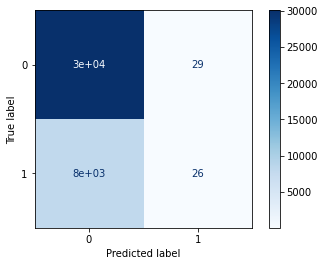

https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-703
Validation
[0 0 0 ... 0 0 0] 

accuracy:  0.8037164728568924
recall:  0.0032816229116945108
precision:  0.3793103448275862
f1:  0.0065069506063294875
ROC AUC:  0.5009867892190912 

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     13761
           1       0.38      0.00      0.01      3352

    accuracy                           0.80     17113
   macro avg       0.59      0.50      0.45     17113
weighted avg       0.72      0.80      0.72     17113



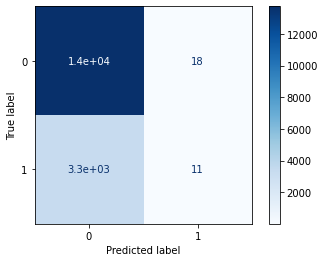

In [56]:
run_model(clf, train, test, validation, "EDA3", ['XGBClassifier', 'EDA3'])

In [57]:
allDatasetFromTimestamp()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [58]:
train

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year
36775,79663627249177,5683597,1,2016-05-11 07:40:04,2016-05-16,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,7,132,137
36776,718169788381286,5683814,0,2016-05-11 07:54:03,2016-05-18,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,7,7,132,139
36777,3139218535988,5711485,1,2016-05-18 07:41:09,2016-05-25,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,7,7,139,146
36779,117342186564746,5415492,1,2016-03-01 13:23:59,2016-05-04,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,64,13,61,125
36780,54139872518,5599591,1,2016-04-19 09:09:23,2016-05-04,54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,15,9,110,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110521,36355337746436,5651072,1,2016-05-03 08:23:40,2016-06-07,53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,35,8,124,159
110522,2572134369293,5651768,1,2016-05-03 09:15:35,2016-06-07,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,35,9,124,159
110524,15576631729893,5630692,1,2016-04-27 16:03:52,2016-06-07,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,41,16,118,159
110525,92134931435557,5630323,1,2016-04-27 15:09:23,2016-06-07,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,41,15,118,159


In [59]:
for idxs in train.sort_values("AppointmentDay").groupby("PatientId").groups.values():
    train.loc[idxs,"sum_No-show"] = train.loc[idxs, "No-show"].shift(1).cumsum().fillna(0)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [64]:
train[train['PatientId']==999479168794227].sort_values(["PatientId","AppointmentDay"])

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,sum_No-show
51731,999479168794227,5615134,0,2016-04-25 11:42:54,2016-05-02,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,7,11,116,123,0.0
80676,999479168794227,5615162,0,2016-04-25 11:46:13,2016-05-09,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,11,116,130,1.0
51735,999479168794227,5732030,0,2016-05-24 10:53:01,2016-05-30,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,6,10,145,151,1.0


In [65]:
for idxs in test.sort_values("AppointmentDay").groupby("PatientId").groups.values():
    test.loc[idxs,"sum_No-show"] = test.loc[idxs, "No-show"].shift(1).cumsum().fillna(0)

In [67]:
test.sort_values(["PatientId","AppointmentDay"])

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,sum_No-show
21106,62497926,5671723,0,2016-05-09 07:05:33,2016-05-11,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,7,130,132,0.0
20744,99512431,5694967,0,2016-05-13 09:12:35,2016-05-13,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,134,134,0.0
25202,122451254,5556646,0,2016-04-07 12:39:53,2016-05-02,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,25,12,98,123,0.0
35471,122451254,5576521,0,2016-04-13 08:35:28,2016-05-09,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,26,8,104,130,1.0
27867,142133299,5683430,1,2016-05-11 07:31:01,2016-05-16,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,5,7,132,137,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32023,999931985292928,5710157,0,2016-05-17 15:22:01,2016-05-17,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,138,138,0.0
62099,999931985292928,5700484,0,2016-05-16 09:29:43,2016-05-17,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,9,137,138,0.0
32033,999931985292928,5736368,0,2016-05-25 08:14:58,2016-05-25,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,146,146,0.0
104616,999931985292928,5772701,0,2016-06-03 16:04:03,2016-06-07,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4,16,155,159,0.0


In [68]:
for idxs in validation.sort_values("AppointmentDay").groupby("PatientId").groups.values():
    validation.loc[idxs,"sum_No-show"] = validation.loc[idxs, "No-show"].shift(1).cumsum().fillna(0)

validation.sort_values(["PatientId","AppointmentDay"])

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,sum_No-show
3950,93779,5712759,1,2016-05-18 09:12:29,2016-05-18,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,139,139,0.0
11009,64851211,5683383,1,2016-05-11 07:28:23,2016-05-13,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,7,132,134,0.0
6674,64851211,5697532,1,2016-05-13 16:22:26,2016-05-17,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,16,134,138,1.0
1792,253866521,5563137,0,2016-04-08 15:13:35,2016-04-29,53,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,21,15,99,120,0.0
706,318385314,5559991,1,2016-04-08 08:22:02,2016-04-29,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,21,8,99,120,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38425,998942679944836,5718039,0,2016-05-19 08:47:20,2016-05-25,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,8,140,146,0.0
5276,999295345736423,5641744,0,2016-04-29 14:15:59,2016-05-03,59,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,4,14,120,124,0.0
1133,999312893251191,5553924,0,2016-04-07 07:51:35,2016-04-29,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,22,7,98,120,0.0
6107,999819435422379,5643353,0,2016-05-02 07:21:58,2016-05-04,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,7,123,125,0.0


In [70]:
date_to_int()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-704
Test
[0 0 0 ... 0 0 0] 

accuracy:  0.7927913748327693
recall:  0.06645016237821634
precision:  0.5559038662486938
f1:  0.11871025326341628
ROC AUC:  0.5261687969453759 

              precision    recall  f1-score   support

           0       0.80      0.99      0.88     30115
           1       0.56      0.07      0.12      8006

    accuracy                           0.79     38121
   macro avg       0.68      0.53      0.50     38121
weighted avg       0.75      0.79      0.72     38121



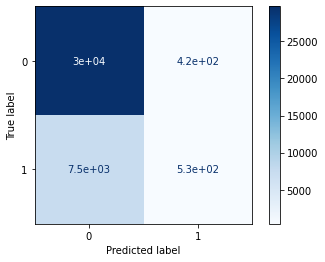

https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-705
Validation
[0 0 0 ... 0 1 0] 

accuracy:  0.8059370069537778
recall:  0.08562052505966587
precision:  0.5285451197053407
f1:  0.14736842105263157
ROC AUC:  0.5335086129404135 

              precision    recall  f1-score   support

           0       0.82      0.98      0.89     13761
           1       0.53      0.09      0.15      3352

    accuracy                           0.81     17113
   macro avg       0.67      0.53      0.52     17113
weighted avg       0.76      0.81      0.74     17113



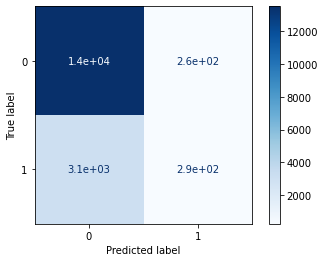

In [71]:
run_model(clf, train, test, validation, "EDA3", ['XGBClassifier', 'EDA3', 'sum_No-show'])

In [72]:
allDatasetFromTimestamp()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [73]:
train

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,sum_No-show
36775,79663627249177,5683597,1,2016-05-11 07:40:04,2016-05-16,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,7,132,137,0.0
36776,718169788381286,5683814,0,2016-05-11 07:54:03,2016-05-18,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,7,7,132,139,0.0
36777,3139218535988,5711485,1,2016-05-18 07:41:09,2016-05-25,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,7,7,139,146,0.0
36779,117342186564746,5415492,1,2016-03-01 13:23:59,2016-05-04,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,64,13,61,125,0.0
36780,54139872518,5599591,1,2016-04-19 09:09:23,2016-05-04,54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,15,9,110,125,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110521,36355337746436,5651072,1,2016-05-03 08:23:40,2016-06-07,53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,35,8,124,159,1.0
110522,2572134369293,5651768,1,2016-05-03 09:15:35,2016-06-07,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,35,9,124,159,1.0
110524,15576631729893,5630692,1,2016-04-27 16:03:52,2016-06-07,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,41,16,118,159,0.0
110525,92134931435557,5630323,1,2016-04-27 15:09:23,2016-06-07,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,41,15,118,159,0.0


In [74]:
# Number of canceled visits for a given patient - in the last 90 days, without including the current visit
for idxs in train.sort_values("AppointmentDay").groupby("PatientId").groups.values():
    train.loc[idxs,"sum1_recent_No-show"] = train.loc[idxs].\
            rolling(window='90D', on="AppointmentDay", min_periods=1, center=False, closed="left")["No-show"].sum().fillna(0)

train.sort_values(["PatientId","AppointmentDay"])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,sum_No-show,sum1_recent_No-show
100517,39217,5751990,1,2016-05-31 10:56:41,2016-06-03,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,10,152,155,0.0,0.0
105430,43741,5760144,0,2016-06-01 14:22:58,2016-06-01,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,14,153,153,0.0,0.0
73303,141724,5637648,0,2016-04-29 07:13:36,2016-05-02,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,7,120,123,0.0,0.0
73228,537615,5637728,1,2016-04-29 07:19:57,2016-05-06,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,7,7,120,127,0.0,0.0
54611,5628261,5680449,0,2016-05-10 11:58:18,2016-05-13,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,11,131,134,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47701,999831834585814,5681860,0,2016-05-10 15:16:56,2016-05-18,57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,8,15,131,139,0.0,0.0
77401,999877415842165,5660015,0,2016-05-04 15:19:22,2016-05-05,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,15,125,126,0.0,0.0
88851,999877415842165,5777078,0,2016-06-06 12:56:18,2016-06-06,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,158,158,0.0,0.0
63048,999968578354866,5740680,1,2016-05-25 15:51:24,2016-05-25,81,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,146,146,0.0,0.0


In [75]:
# Number of canceled visits for a given patient - in the last 90 days, without including the current visit
for idxs in test.sort_values("AppointmentDay").groupby("PatientId").groups.values():
    test.loc[idxs,"sum1_recent_No-show"] = test.loc[idxs].\
            rolling(window='90D', on="AppointmentDay", min_periods=1, center=False, closed="left")["No-show"].sum().fillna(0)

test.sort_values(["PatientId","AppointmentDay"])

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,sum_No-show,sum1_recent_No-show
21106,62497926,5671723,0,2016-05-09 07:05:33,2016-05-11,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,7,130,132,0.0,0.0
20744,99512431,5694967,0,2016-05-13 09:12:35,2016-05-13,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,134,134,0.0,0.0
25202,122451254,5556646,0,2016-04-07 12:39:53,2016-05-02,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,25,12,98,123,0.0,0.0
35471,122451254,5576521,0,2016-04-13 08:35:28,2016-05-09,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,26,8,104,130,1.0,1.0
27867,142133299,5683430,1,2016-05-11 07:31:01,2016-05-16,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,5,7,132,137,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32023,999931985292928,5710157,0,2016-05-17 15:22:01,2016-05-17,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,138,138,0.0,0.0
62099,999931985292928,5700484,0,2016-05-16 09:29:43,2016-05-17,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,9,137,138,0.0,0.0
32033,999931985292928,5736368,0,2016-05-25 08:14:58,2016-05-25,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,146,146,0.0,0.0
104616,999931985292928,5772701,0,2016-06-03 16:04:03,2016-06-07,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4,16,155,159,0.0,0.0


In [76]:
# Number of canceled visits for a given patient - in the last 90 days, without including the current visit
for idxs in validation.sort_values("AppointmentDay").groupby("PatientId").groups.values():
    validation.loc[idxs,"sum1_recent_No-show"] = validation.loc[idxs].\
            rolling(window='90D', on="AppointmentDay", min_periods=1, center=False, closed="left")["No-show"].sum().fillna(0)

validation.sort_values(["PatientId","AppointmentDay"])

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,sum_No-show,sum1_recent_No-show
3950,93779,5712759,1,2016-05-18 09:12:29,2016-05-18,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,139,139,0.0,0.0
11009,64851211,5683383,1,2016-05-11 07:28:23,2016-05-13,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,7,132,134,0.0,0.0
6674,64851211,5697532,1,2016-05-13 16:22:26,2016-05-17,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,16,134,138,1.0,1.0
1792,253866521,5563137,0,2016-04-08 15:13:35,2016-04-29,53,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,21,15,99,120,0.0,0.0
706,318385314,5559991,1,2016-04-08 08:22:02,2016-04-29,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,21,8,99,120,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38425,998942679944836,5718039,0,2016-05-19 08:47:20,2016-05-25,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,8,140,146,0.0,0.0
5276,999295345736423,5641744,0,2016-04-29 14:15:59,2016-05-03,59,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,4,14,120,124,0.0,0.0
1133,999312893251191,5553924,0,2016-04-07 07:51:35,2016-04-29,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,22,7,98,120,0.0,0.0
6107,999819435422379,5643353,0,2016-05-02 07:21:58,2016-05-04,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,7,123,125,0.0,0.0


In [77]:
date_to_int()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-706
Test
[0 0 0 ... 0 0 0] 

accuracy:  0.7927913748327693
recall:  0.06645016237821634
precision:  0.5559038662486938
f1:  0.11871025326341628
ROC AUC:  0.5261687969453759 

              precision    recall  f1-score   support

           0       0.80      0.99      0.88     30115
           1       0.56      0.07      0.12      8006

    accuracy                           0.79     38121
   macro avg       0.68      0.53      0.50     38121
weighted avg       0.75      0.79      0.72     38121



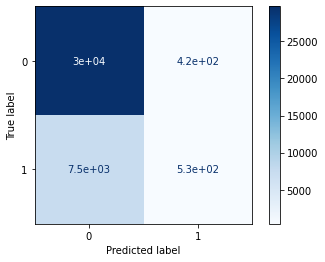

https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-707
Validation
[0 0 0 ... 0 1 0] 

accuracy:  0.8059370069537778
recall:  0.08562052505966587
precision:  0.5285451197053407
f1:  0.14736842105263157
ROC AUC:  0.5335086129404135 

              precision    recall  f1-score   support

           0       0.82      0.98      0.89     13761
           1       0.53      0.09      0.15      3352

    accuracy                           0.81     17113
   macro avg       0.67      0.53      0.52     17113
weighted avg       0.76      0.81      0.74     17113



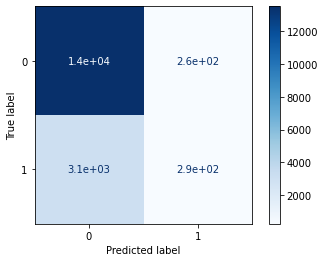

In [78]:
run_model(clf, train, test, validation, "EDA3", ['XGBClassifier', 'EDA3', 'sum1_recent_No-show'])

In [79]:
allDatasetFromTimestamp()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [80]:
for idxs in train.sort_values("AppointmentDay").groupby("PatientId").groups.values():          
    # Last successful visit and number of canceled visits since a last successful visit   
    last_show = pd.Timestamp(0)
    sumRecentNoShows = 0
    for i in idxs:
        #train.loc[i,"_lastShow"] = last_show
        train.loc[i,"_sumRecentNoShows"] = sumRecentNoShows
        if train.loc[i,"No-show"] == 0:
            last_show = train.loc[i,"AppointmentDay"]
            sumRecentNoShows = 0
        else:
            sumRecentNoShows += 1   
            
train.sort_values(["PatientId","AppointmentDay"])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,sum_No-show,sum1_recent_No-show,_sumRecentNoShows
100517,39217,5751990,1,2016-05-31 10:56:41,2016-06-03,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,10,152,155,0.0,0.0,0.0
105430,43741,5760144,0,2016-06-01 14:22:58,2016-06-01,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,14,153,153,0.0,0.0,0.0
73303,141724,5637648,0,2016-04-29 07:13:36,2016-05-02,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,7,120,123,0.0,0.0,0.0
73228,537615,5637728,1,2016-04-29 07:19:57,2016-05-06,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,7,7,120,127,0.0,0.0,0.0
54611,5628261,5680449,0,2016-05-10 11:58:18,2016-05-13,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,11,131,134,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47701,999831834585814,5681860,0,2016-05-10 15:16:56,2016-05-18,57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,8,15,131,139,0.0,0.0,0.0
77401,999877415842165,5660015,0,2016-05-04 15:19:22,2016-05-05,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,15,125,126,0.0,0.0,0.0
88851,999877415842165,5777078,0,2016-06-06 12:56:18,2016-06-06,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,158,158,0.0,0.0,0.0
63048,999968578354866,5740680,1,2016-05-25 15:51:24,2016-05-25,81,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,146,146,0.0,0.0,0.0


In [81]:
for idxs in test.sort_values("AppointmentDay").groupby("PatientId").groups.values():          
    # Last successful visit and number of canceled visits since a last successful visit   
    last_show = pd.Timestamp(0)
    sumRecentNoShows = 0
    for i in idxs:
        #train.loc[i,"_lastShow"] = last_show
        test.loc[i,"_sumRecentNoShows"] = sumRecentNoShows
        if test.loc[i,"No-show"] == 0:
            last_show = test.loc[i,"AppointmentDay"]
            sumRecentNoShows = 0
        else:
            sumRecentNoShows += 1   
            
test.sort_values(["PatientId","AppointmentDay"])

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,sum_No-show,sum1_recent_No-show,_sumRecentNoShows
21106,62497926,5671723,0,2016-05-09 07:05:33,2016-05-11,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,7,130,132,0.0,0.0,0.0
20744,99512431,5694967,0,2016-05-13 09:12:35,2016-05-13,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,134,134,0.0,0.0,0.0
25202,122451254,5556646,0,2016-04-07 12:39:53,2016-05-02,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,25,12,98,123,0.0,0.0,0.0
35471,122451254,5576521,0,2016-04-13 08:35:28,2016-05-09,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,26,8,104,130,1.0,1.0,1.0
27867,142133299,5683430,1,2016-05-11 07:31:01,2016-05-16,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,5,7,132,137,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32023,999931985292928,5710157,0,2016-05-17 15:22:01,2016-05-17,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,138,138,0.0,0.0,0.0
62099,999931985292928,5700484,0,2016-05-16 09:29:43,2016-05-17,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,9,137,138,0.0,0.0,0.0
32033,999931985292928,5736368,0,2016-05-25 08:14:58,2016-05-25,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,146,146,0.0,0.0,0.0
104616,999931985292928,5772701,0,2016-06-03 16:04:03,2016-06-07,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4,16,155,159,0.0,0.0,0.0


In [82]:
for idxs in validation.sort_values("AppointmentDay").groupby("PatientId").groups.values():          
    # Last successful visit and number of canceled visits since a last successful visit   
    last_show = pd.Timestamp(0)
    sumRecentNoShows = 0
    for i in idxs:
        #train.loc[i,"_lastShow"] = last_show
        validation.loc[i,"_sumRecentNoShows"] = sumRecentNoShows
        if validation.loc[i,"No-show"] == 0:
            last_show = validation.loc[i,"AppointmentDay"]
            sumRecentNoShows = 0
        else:
            sumRecentNoShows += 1   
            
validation.sort_values(["PatientId","AppointmentDay"])

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,sum_No-show,sum1_recent_No-show,_sumRecentNoShows
3950,93779,5712759,1,2016-05-18 09:12:29,2016-05-18,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,139,139,0.0,0.0,0.0
11009,64851211,5683383,1,2016-05-11 07:28:23,2016-05-13,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,7,132,134,0.0,0.0,0.0
6674,64851211,5697532,1,2016-05-13 16:22:26,2016-05-17,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,16,134,138,1.0,1.0,1.0
1792,253866521,5563137,0,2016-04-08 15:13:35,2016-04-29,53,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,21,15,99,120,0.0,0.0,0.0
706,318385314,5559991,1,2016-04-08 08:22:02,2016-04-29,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,21,8,99,120,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38425,998942679944836,5718039,0,2016-05-19 08:47:20,2016-05-25,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,8,140,146,0.0,0.0,0.0
5276,999295345736423,5641744,0,2016-04-29 14:15:59,2016-05-03,59,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,4,14,120,124,0.0,0.0,0.0
1133,999312893251191,5553924,0,2016-04-07 07:51:35,2016-04-29,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,22,7,98,120,0.0,0.0,0.0
6107,999819435422379,5643353,0,2016-05-02 07:21:58,2016-05-04,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,7,123,125,0.0,0.0,0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-708
Test
[0 0 0 ... 0 0 0] 

accuracy:  0.7941554523753311
recall:  0.0728203847114664
precision:  0.5789473684210527
f1:  0.129368689670476
ROC AUC:  0.5293705111337508 

              precision    recall  f1-score   support

           0       0.80      0.99      0.88     30115
           1       0.58      0.07      0.13      8006

    accuracy                           0.79     38121
   macro avg       0.69      0.53      0.51     38121
weighted avg       0.75      0.79      0.72     38121



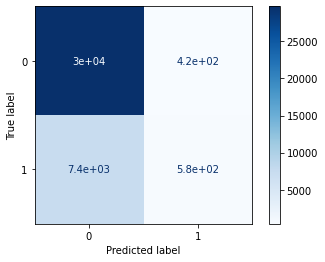

https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-709
Validation
[0 0 0 ... 0 1 0] 

accuracy:  0.8089171974522293
recall:  0.09218377088305489
precision:  0.5764925373134329
f1:  0.15895061728395063
ROC AUC:  0.5378439383446595 

              precision    recall  f1-score   support

           0       0.82      0.98      0.89     13761
           1       0.58      0.09      0.16      3352

    accuracy                           0.81     17113
   macro avg       0.70      0.54      0.53     17113
weighted avg       0.77      0.81      0.75     17113



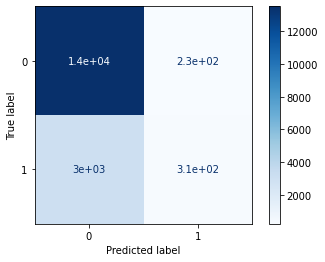

In [83]:
date_to_int()
run_model(clf, train, test, validation, "EDA3", ['XGBClassifier', 'EDA3', '_sumRecentNoShows'])